In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.losses import mse
from keras.utils import plot_model
from keras import backend as K
from keras.layers import BatchNormalization, Activation, Flatten
from keras.layers.convolutional import Conv2DTranspose, Conv2D


from skimage.io import imread,imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os

from glob import glob

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Helper functions

In [2]:
def ImageDonwSamplingAndScaling(img,resize,max_value=255):
  
    orgHeight, orgWidth = img.shape[:2]
    size = (orgHeight//resize, orgWidth//resize)


    return cv2.resize(img, size)/max_value



#8×8のサイズに切り出す
def cut_img(img,height=8, width=8,stride=2):
    print("cutting images ...")
    x_out = []
    img_h = img.shape[0]
    img_w=img.shape[1]
    
    for x_idx in range((img_h-height+1)//stride+1):
        for y_idx in range((img_w-width+1)//stride+1):
            x_out.append(img[x_idx:x_idx+height,y_idx:y_idx+width])

    print("Complete.")
    x_out = np.array(x_out)

    return x_out
  
  #8×8のサイズに切り出す
def cut_img_rand(img, number, height=8, width=8):
    x_out = []
    img_h = img.shape[0]
    img_w=img.shape[1]

    for i in range(number):
        shape_1 = np.random.randint(0,img_h-height)
        shape_2 = np.random.randint(0,img_w-width)
        temp = img[ shape_1:shape_1+height, shape_2:shape_2+width]
        x_out.append(temp)

    x_out = np.array(x_out)

    return x_out
  
def img_sampler(img_list,number, height=8, width=8):
    x_out=[]
    
    count=0
    for img in img_list:
        if count==0:
            x_out=cut_img_rand(img, number, height, width)
        else:
            x_out=np.append(x_out,cut_img_rand(img, number, height, width),axis=0)
        count+=1
    return x_out
  
  
#ヒートマップの描画
def save_img(x_normal, x_anomaly, img_normal, img_anomaly, name):
    path = 'images/'
    if not os.path.exists(path):
          os.mkdir(path)

    #　※注意　評価したヒートマップを1～10に正規化
    img_max = np.max([img_normal, img_anomaly])
    img_min = np.min([img_normal, img_anomaly])
    img_normal = (img_normal-img_min)/(img_max-img_min) * 9 + 1
    img_anomaly = (img_anomaly-img_min)/(img_max-img_min) * 9 + 1

    plt.figure()
    plt.subplot(2, 2, 1)
    plt.imshow(x_normal[0,:,:,0], cmap='gray')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.imshow(img_normal[0,:,:,0], cmap='Reds',norm=colors.LogNorm())
    plt.axis('off')
    plt.colorbar()
    plt.clim(1, 10)

    plt.title(name + "normal")

    plt.subplot(2, 2, 3)
    plt.imshow(x_anomaly[0,:,:,0], cmap='gray')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.imshow(img_anomaly[0,:,:,0], cmap='Reds',norm=colors.LogNorm())
    plt.axis('off')
    plt.colorbar()
    plt.clim(1, 10)

    plt.title(name + "anomaly")

    plt.savefig(path + name +".png")
    plt.show()
    plt.close()

#ヒートマップの計算
def evaluate_img(model, x_normal, x_anomaly, name, height=8, width=8, move=2):
    img_normal = np.zeros((x_normal.shape))
    img_anomaly = np.zeros((x_normal.shape))

    for i in range(int((x_normal.shape[1]-height)/move)+1):
        for j in range(int((x_normal.shape[2]-width)/move)+1):
            x_sub_normal = x_normal[0, i*move:i*move+height, j*move:j*move+width, 0]
            x_sub_anomaly = x_anomaly[0, i*move:i*move+height, j*move:j*move+width, 0]
            x_sub_normal = x_sub_normal.reshape(1, height, width, 1)
            x_sub_anomaly = x_sub_anomaly.reshape(1, height, width, 1)

            #従来手法
            if name == "old_":
                #正常のスコア
                normal_score = model.evaluate(x_sub_normal, batch_size=1, verbose=0)
                img_normal[0, i*move:i*move+height, j*move:j*move+width, 0] +=  normal_score

                #異常のスコア
                anomaly_score = model.evaluate(x_sub_anomaly, batch_size=1, verbose=0)
                img_anomaly[0, i*move:i*move+height, j*move:j*move+width, 0] +=  anomaly_score

            #提案手法
            else:
                #正常のスコア
                mu, sigma = model.predict(x_sub_normal, batch_size=1, verbose=0)
                loss = 0
                for k in range(height):
                    for l in range(width):
                        loss += 0.5 * (x_sub_normal[0,k,l,0] - mu[0,k,l,0])**2 / sigma[0,k,l,0]
                img_normal[0, i*move:i*move+height, j*move:j*move+width, 0] +=  loss

                #異常のスコア
                mu, sigma = model.predict(x_sub_anomaly, batch_size=1, verbose=0)
                loss = 0
                for k in range(height):
                    for l in range(width):
                        loss += 0.5 * (x_sub_anomaly[0,k,l,0] - mu[0,k,l,0])**2 / sigma[0,k,l,0]
                        
                img_anomaly[0, i*move:i*move+height, j*move:j*move+width, 0] +=  loss

    save_img(x_normal, x_anomaly, img_normal, img_anomaly, name)



# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def GetRawAnomaly(model,x_normal,  height=8, width=8, move=2):
    img_normal = np.zeros((x_normal.shape))

    for i in range(int((x_normal.shape[1]-height)/move)+1):
        for j in range(int((x_normal.shape[2]-width)/move)+1):
            x_sub_normal = x_normal[0, i*move:i*move+height, j*move:j*move+width, 0]
            x_sub_normal = x_sub_normal.reshape(1, height, width, 1)


            #提案手法
            #正常のスコア
            mu, sigma = model.predict(x_sub_normal, batch_size=1, verbose=0)
            loss = 0
            for k in range(height):
                for l in range(width):
                    loss += 0.5 * (x_sub_normal[0,k,l,0] - mu[0,k,l,0])**2 / sigma[0,k,l,0]
            img_normal[0, i*move:i*move+height, j*move:j*move+width, 0] +=  loss

    return img_normal
    
  
  
#ヒートマップの計算
def GetAnomaly(model, x_normal, x_anomaly, img_min,img_max, height=8, width=8, move=2,mode='subtraction'):
    img_normal = np.zeros((x_normal.shape))
    img_anomaly = np.zeros((x_normal.shape))
    img_subtract = np.zeros((x_normal.shape))

    for i in range(int((x_normal.shape[1]-height)/move)+1):
        for j in range(int((x_normal.shape[2]-width)/move)+1):
            x_sub_normal = x_normal[0, i*move:i*move+height, j*move:j*move+width, 0]
            x_sub_anomaly = x_anomaly[0, i*move:i*move+height, j*move:j*move+width, 0]
            x_sub_normal = x_sub_normal.reshape(1, height, width, 1)
            x_sub_anomaly = x_sub_anomaly.reshape(1, height, width, 1)

                
              

            #提案手法
            #正常のスコア
            mu, sigma = model.predict(x_sub_normal, batch_size=1, verbose=0)
            loss = 0
            for k in range(height):
                for l in range(width):
                    loss += 0.5 * (x_sub_normal[0,k,l,0] - mu[0,k,l,0])**2 / sigma[0,k,l,0]
            img_normal[0, i*move:i*move+height, j*move:j*move+width, 0] +=  loss

            #異常のスコア
            mu, sigma = model.predict(x_sub_anomaly, batch_size=1, verbose=0)
            loss = 0
            for k in range(height):
                for l in range(width):
                    loss += 0.5 * (x_sub_anomaly[0,k,l,0] - mu[0,k,l,0])**2 / sigma[0,k,l,0]

            img_anomaly[0, i*move:i*move+height, j*move:j*move+width, 0] +=  loss

    img_normal = (img_normal-img_min)/(img_max-img_min) 
    img_anomaly = (img_anomaly-img_min)/(img_max-img_min)
   
    #img_normal=img_normal-np.average(img_normal)
    #img_anomaly=img_anomaly-np.average(img_normal)
    img_subtract=img_anomaly-img_normal

    if mode=='subtraction':
        return img_subtract
    elif mode=='self':
        return img_anomaly
    else:
        print('mode error')

def AnomalyOverlayImg(img,anomaly_map,alpha=0.5):

    # ヒートマップの後処理
    heatmap=anomaly_map



    # 元の画像と同じサイズになるようにヒートマップのサイズを変更
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # ヒートマップをRGBに変換
    heatmap = np.uint8(255 * heatmap)

    # ヒートマップを元画像に適用
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)[:,:,::-1]
    print(heatmap.shape)

    # 0.4はヒートマップの強度係数
    #superimposed_img = heatmap * 0.4 + img
    dst = cv2.addWeighted(img, 0.8, heatmap, alpha, 0)
  
    return dst

In [4]:
video_path='ball_video.MOV'

In [4]:
data_list=glob("/content/drive/My Drive/ColabSandbox/data/*")
data_list

['/content/drive/My Drive/ColabSandbox/data/IMG_3710.jpg',
 '/content/drive/My Drive/ColabSandbox/data/IMG_3709.jpg',
 '/content/drive/My Drive/ColabSandbox/data/one_ball.jpg',
 '/content/drive/My Drive/ColabSandbox/data/one_ball_anomaly.jpg',
 '/content/drive/My Drive/ColabSandbox/data/ball_video.MOV']

In [5]:
#video_path = '/content/drive/My Drive/ColabSandbox/data/ball_video.MOV'
cap = cv2.VideoCapture(video_path)

num = 0
pics=[]
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        pics.append(frame)
        #cv2.imwrite("picture{:0=3}".format(num)+".jpg",frame)
        #print("save picture{:0=3}".format(num)+".jpg")
        num += 1
    else:
        break

cap.release()

In [6]:
num

723

C:\Users\Sakata\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


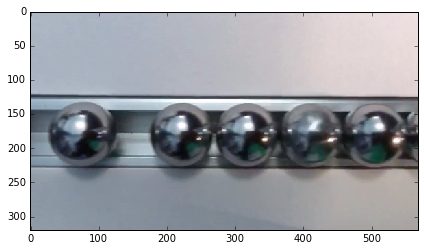

In [7]:
imshow(pics[288]) #263 288

C:\Users\Sakata\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


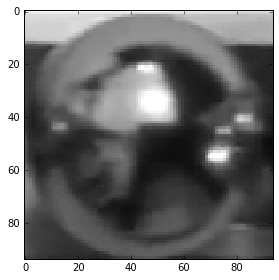

In [8]:
template=pics[263][133:133+94,320:320+94]
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
imshow(template)

C:\Users\Sakata\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


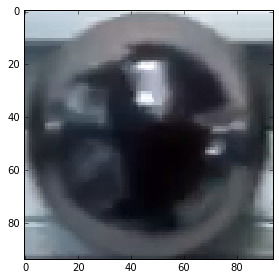

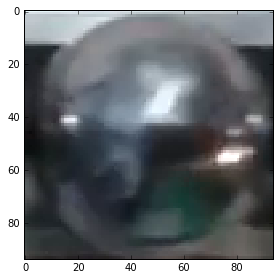

In [9]:

anomaly1_rgb=pics[263][133:133+template.shape[0],172:172+template.shape[1]]
anomaly1_grey=cv2.cvtColor(anomaly1_rgb, cv2.COLOR_BGR2GRAY)
imshow(anomaly1_rgb)
plt.show()
anomaly2_rgb=pics[288][133:133+template.shape[0],362:362+template.shape[1]]
anomaly2_grey=cv2.cvtColor(anomaly2_rgb, cv2.COLOR_BGR2GRAY)
imshow(anomaly2_rgb)
plt.show()


In [10]:
#template=cv2.imread('/content/drive/My Drive/ColabSandbox/data/one_ball.jpg',0)
#imshow(template)
#anomaly_rgb=cv2.imread('/content/drive/My Drive/ColabSandbox/data/one_ball_anomaly.jpg')[:,:,::-1]
#imshow(anomaly_rgb)
#plt.show()
#anomaly=cv2.imread('/content/drive/My Drive/ColabSandbox/data/one_ball_anomaly.jpg',0)
#imshow(anomaly)
#plt.show()

C:\Users\Sakata\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


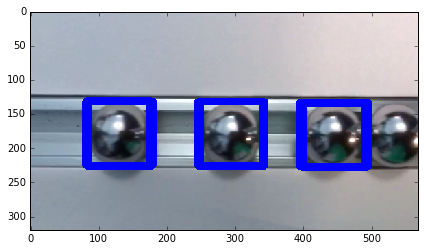

In [11]:
img_rgb_original=pics[250]
img_rgb=img_rgb_original.copy()
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
imshow(img_gray)


w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.69
loc = np.where( res >= threshold)
loc



for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
imshow(img_rgb)

In [12]:
def PickMatchedImgs(pics_array,template):
    matched_imgs=[]

    for img_rgb_original in pics_array:
        img_rgb=img_rgb_original.copy()
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)


        w, h = template.shape[::-1]

        res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
        threshold = 0.69
        loc = np.where( res >= threshold)

    for pt in zip(*loc[::-1]):
            #cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
            matched_imgs.append(img_gray[pt[1]: pt[1] + h,pt[0]:pt[0] + w])

    return matched_imgs

In [13]:
matched_imgs=PickMatchedImgs(pics[:250],template)
len(matched_imgs)

287

C:\Users\Sakata\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


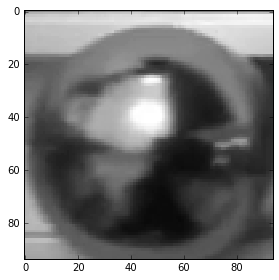

In [14]:
imshow(matched_imgs[0])

In [15]:
matched_imgs[0].max()

255

C:\Users\Sakata\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


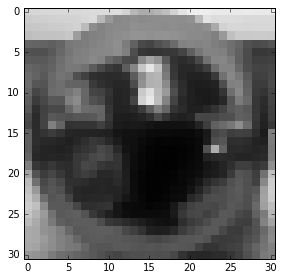

In [16]:
resize=3

matched_imgs_resize=[ImageDonwSamplingAndScaling(img,resize,max_value=255) for img in matched_imgs]
anomaly1_resize=ImageDonwSamplingAndScaling(anomaly1_grey,resize,max_value=255)
anomaly2_resize=ImageDonwSamplingAndScaling(anomaly2_grey,resize,max_value=255)
template_resize=ImageDonwSamplingAndScaling(template,resize,max_value=255)
anomaly1_resize.shape

imshow(anomaly1_resize)

## Data preprocess (sampling)

In [17]:
image_size=8

sampling_num=5
cut_imgs=img_sampler(img_list=matched_imgs_resize,number=sampling_num, height=image_size, width=image_size)[:,:,:,None]
cut_imgs.shape

(1435, 8, 8, 1)

In [18]:
# network parameters
input_shape=(image_size, image_size, 1)
batch_size = 128
latent_dim = 2
epochs = 10
Nc = 64


# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(Nc, kernel_size=2, strides=2)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(2*Nc, kernel_size=2, strides=2)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(2*Nc, kernel_size=2, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2DTranspose(Nc, kernel_size=2, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x1 = Conv2DTranspose(1, kernel_size=4, padding='same')(x)
x1 = BatchNormalization()(x1)
out1 = Activation('sigmoid')(x1)#out.shape=(n,8,8,1)

x2 = Conv2DTranspose(1, kernel_size=4, padding='same')(x)
x2 = BatchNormalization()(x2)
out2 = Activation('sigmoid')(x2)#out.shape=(n,8,8,1)

decoder = Model(latent_inputs, [out1, out2], name='decoder')
decoder.summary()

# build VAE model
outputs_mu, outputs_sigma = decoder(encoder(inputs)[2])
vae = Model(inputs, [outputs_mu, outputs_sigma], name='vae_mlp')

# VAE loss
m_vae_loss = (K.flatten(inputs) - K.flatten(outputs_mu))**2 / (K.flatten(outputs_sigma))**2
m_vae_loss = 0.5 * K.sum(m_vae_loss)

a_vae_loss = K.log(2 * 3.14 * (K.flatten(outputs_sigma))**2)
a_vae_loss = 0.5 * K.sum(a_vae_loss)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(kl_loss + m_vae_loss + a_vae_loss)/(image_size**2)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 4, 64)     320         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 4, 4, 64)     256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 4, 4, 64)     0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [19]:
# train the autoencoder
vae.fit(cut_imgs,
        epochs=50,
        batch_size=batch_size)
        #validation_data=(x_test, None))


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
133435/133435 [==============================] - 24s 178us/step - loss: 19.7843
Epoch 2/50
133435/133435 [==============================] - 21s 157us/step - loss: -39.9241
Epoch 3/50
133435/133435 [==============================] - 21s 156us/step - loss: -90.9438
Epoch 4/50
133435/133435 [==============================] - 21s 156us/step - loss: -105.7223
Epoch 5/50
133435/133435 [==============================] - 21s 156us/step - loss: -112.0208
Epoch 6/50
133435/133435 [==============================] - 21s 156us/step - loss: -114.9055
Epoch 7/50
133435/133435 [==============================] - 21s 155us/step - loss: -117.9876
Epoch 8/50
133435/133435 [==============================] - 21s 155us/step - loss: -119.2735
Epoch 9/50
133435/133435 [==============================] - 21s 154us/step - loss: -122.1978
Epoch 10/50
133435/133435 [==============================] - 21s 155us/step - loss: -123.9526
Epoch 11/50
133435/133435

In [20]:
#from keras.models import load_model,load_weights
vae.load_weights('vae_model.h5')

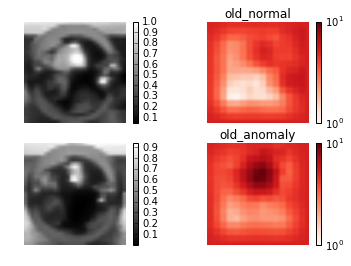

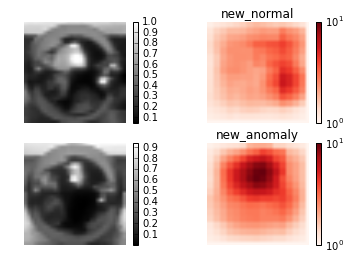

----------------------------------------


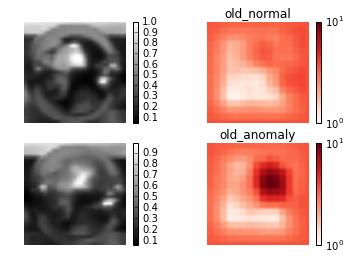

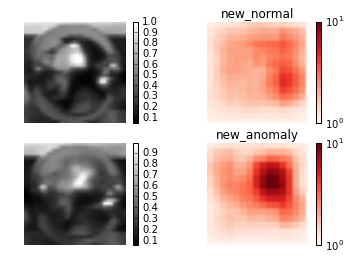

In [21]:
#従来手法の可視化
evaluate_img(vae, template_resize[None,:,:,None], anomaly1_resize[None,:,:,None], "old_",height=image_size, width=image_size, move=2)

#提案手法の可視化
evaluate_img(vae,  template_resize[None,:,:,None], anomaly1_resize[None,:,:,None], "new_",height=image_size, width=image_size, move=2)

print('-'*40)
#従来手法の可視化
evaluate_img(vae, template_resize[None,:,:,None], anomaly2_resize[None,:,:,None], "old_",height=image_size, width=image_size, move=2)

#提案手法の可視化
evaluate_img(vae,  template_resize[None,:,:,None], anomaly2_resize[None,:,:,None], "new_",height=image_size, width=image_size, move=2)

277.77454263942644
0.0
(94, 94, 3)


C:\Users\Sakata\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


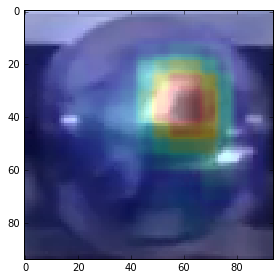

In [22]:
vmin=GetRawAnomaly(vae,template_resize[None,:,:,None],image_size,image_size).min()
vmax=GetRawAnomaly(vae,anomaly2_resize[None,:,:,None],image_size,image_size).max()

print(vmax)
print(vmin)
anomaly_map=GetAnomaly(vae, template_resize[None,:,:,None], anomaly2_resize[None,:,:,None],vmin,vmax,image_size,image_size, move=2,mode='self')
dst=AnomalyOverlayImg(anomaly2_rgb, anomaly_map[0,:,:,0],alpha=0.3)
imshow(dst)

In [23]:
anomaly_map.shape

(1, 31, 31, 1)

In [24]:
def RemoveOverlapBox(boxes,ratio):
    i=0
    while True:
        for k in list(range(i+1,len(boxes)))[::-1]:
            if IsBboxOverlap(boxes[i],boxes[k],ratio):
                del boxes[k]
        i+=1

        if i>len(boxes)-3:
            break

def IsBboxOverlap(bbox1,bbox2,ratio):
  
    '''
    bbox=(x,y,h,w)
    '''
    center_x1=bbox1[0]+bbox1[2]/2
    center_y1=bbox1[1]+bbox1[3]/2
    center_x2=bbox2[0]+bbox2[2]/2
    center_y2=bbox2[1]+bbox2[3]/2


    if (np.abs(center_x1-center_x2)<((bbox1[2]+bbox2[2])/2*ratio))&(np.abs(center_y1-center_y2)<((bbox1[3]+bbox2[3])/2*ratio)):
        return True
    else:
        return False


(94, 94, 3)


C:\Users\Sakata\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


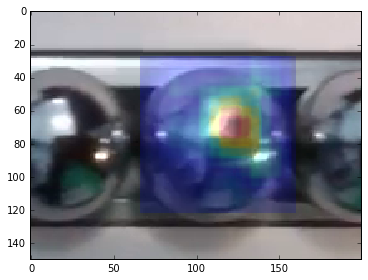

In [28]:
def DetectionPerPic(img_rgb_original,resize,vae,template,template_resize,vmin,vmax,height,width,move,mode):
    img_rgb=img_rgb_original.copy()
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

    # template matching
    w, h = template.shape[::-1]

    res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
    threshold = 0.69

    # 左上の座標

    loc = np.where( res >= threshold)

    # matched coordinate
    bboxes=[(loc[0][i],loc[1][i],h,w) for i in range(len(loc[0]))]
    RemoveOverlapBox(bboxes,0.5)

    resize

    img_rgb_detected=img_rgb_original.copy()

    for box in bboxes:
        x=box[0]
        y=box[1]
        h=box[2]
        w=box[3]
        picked_img_rgb=img_rgb_original[x:x+h,y:y+w]
        picked_img_grey=cv2.cvtColor(picked_img_rgb, cv2.COLOR_BGR2GRAY)
        picked_img_grey=ImageDonwSamplingAndScaling(picked_img_grey,resize,max_value=255)
        anomaly_map=GetAnomaly(vae, template_resize[None,:,:,None], picked_img_grey[None,:,:,None],vmin,vmax,height,width, move=move,mode=mode)
        dst=AnomalyOverlayImg(picked_img_rgb, anomaly_map[0,:,:,0],alpha=0.3)

        img_rgb_detected[x:x+h,y:y+w]=dst
    #imshow(img_rgb_detected)
    #plt.show()

    return img_rgb_detected


img_rgb_detected=DetectionPerPic(pics[288][100:250,300:500],resize,vae,template,template_resize,vmin,vmax,image_size,image_size,move=2,mode='self')
imshow(img_rgb_detected)

In [30]:
output_path='ball_detected_video.mp4'
from PIL import Image, ImageFont, ImageDraw


vid = cv2.VideoCapture(video_path)


if not vid.isOpened():
    raise IOError("Couldn't open webcam or video")
video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
video_fps       = vid.get(cv2.CAP_PROP_FPS)
video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                    int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
isOutput = True if output_path != "" else False

# Read first frame
success, frame = vid.read()
# quit if unable to read the video file
#if not success:
#    print('Failed to read video')
#    sys.exit(1)
    
# Create MultiTracker object
#multiTracker = cv2.MultiTracker_create()
# Initialize MultiTracker 
#for bbox in bboxes:
#    multiTracker.add(cv2.TrackerKCF_create(), frame, bbox)


if isOutput:
    print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
    out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
accum_time = 0
curr_fps = 0
fps = "FPS: ??"
prev_time = cv2.getTickCount()


while True:
    return_value, frame = vid.read()
    if return_value==False:
        break
        
    # Start timer
    start = cv2.getTickCount()


    # detection image
    #image = Image.fromarray(frame)
    image=DetectionPerPic(frame,resize,vae,template,template_resize,vmin,vmax,image_size,image_size,move=2,mode='self')


    # FPSを計算する
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - start);

    # 検出した場所に四角を書く
    '''
    if track:
        # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (0,255,0), 2, 1)
    else :
        # トラッキングが外れたら警告を表示する
        cv2.putText(frame, "Failure", (10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA);
    '''
    # FPSを表示する
    #cv2.putText(frame, "FPS : " + str(int(fps)), (10,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA);

    #image = Image.fromarray(frame)

    result = np.asarray(image[:,:,::-1])
    curr_time = cv2.getTickCount()
    exec_time = curr_time - prev_time
    prev_time = curr_time
    accum_time = accum_time + exec_time
    curr_fps = curr_fps + 1
    if accum_time > 1:
        accum_time = accum_time - 1
        fps = "FPS: " + str(curr_fps)
        curr_fps = 0
    #cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    #            fontScale=0.50, color=(255, 0, 0), thickness=2)
    #cv2.namedWindow("result", cv2.WINDOW_NORMAL)
    #cv2.imshow("result", result)
    if isOutput:
        out.write(result)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    #imshow( result)
    #plt.show()

# キャプチャをリリースして、ウィンドウをすべて閉じる
vid.release()
out.release()


!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 94, 3)
(94, 9

In [31]:
output_path='ball_normal_video.mp4'
from PIL import Image, ImageFont, ImageDraw


vid = cv2.VideoCapture(video_path)


if not vid.isOpened():
    raise IOError("Couldn't open webcam or video")
video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
video_fps       = vid.get(cv2.CAP_PROP_FPS)
video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                    int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
isOutput = True if output_path != "" else False

# Read first frame
success, frame = vid.read()
# quit if unable to read the video file
#if not success:
#    print('Failed to read video')
#    sys.exit(1)
    
# Create MultiTracker object
#multiTracker = cv2.MultiTracker_create()
# Initialize MultiTracker 
#for bbox in bboxes:
#    multiTracker.add(cv2.TrackerKCF_create(), frame, bbox)


if isOutput:
    print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
    out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
accum_time = 0
curr_fps = 0
fps = "FPS: ??"
prev_time = cv2.getTickCount()


while True:
    return_value, frame = vid.read()
    if return_value==False:
        break
        
    # Start timer
    start = cv2.getTickCount()


    # detection image
    #image = Image.fromarray(frame)
    image=frame


    # FPSを計算する
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - start);

    # 検出した場所に四角を書く
    '''
    if track:
        # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (0,255,0), 2, 1)
    else :
        # トラッキングが外れたら警告を表示する
        cv2.putText(frame, "Failure", (10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA);
    '''
    # FPSを表示する
    #cv2.putText(frame, "FPS : " + str(int(fps)), (10,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA);

    #image = Image.fromarray(frame)

    result = np.asarray(image[:,:,::-1])
    curr_time = cv2.getTickCount()
    exec_time = curr_time - prev_time
    prev_time = curr_time
    accum_time = accum_time + exec_time
    curr_fps = curr_fps + 1
    if accum_time > 1:
        accum_time = accum_time - 1
        fps = "FPS: " + str(curr_fps)
        curr_fps = 0
    #cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    #            fontScale=0.50, color=(255, 0, 0), thickness=2)
    #cv2.namedWindow("result", cv2.WINDOW_NORMAL)
    #cv2.imshow("result", result)
    if isOutput:
        out.write(result)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    #imshow( result)
    #plt.show()

# キャプチャをリリースして、ウィンドウをすべて閉じる
vid.release()
out.release()


!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>


In [36]:
#video_path = '/content/drive/My Drive/ColabSandbox/data/ball_video.MOV'
cap = cv2.VideoCapture('ball_normal_video.mp4')
#cap = cv2.VideoCapture('ball_detected_video.mp4')

num = 0
normal_pics=[]
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        normal_pics.append(frame)
        #cv2.imwrite("picture{:0=3}".format(num)+".jpg",frame)
        #print("save picture{:0=3}".format(num)+".jpg")
        num += 1
    else:
        break


In [41]:
output_path='ball_detected_joint_video.mp4'
video_path='ball_detected_video.mp4'
from PIL import Image, ImageFont, ImageDraw


vid = cv2.VideoCapture(video_path)


if not vid.isOpened():
    raise IOError("Couldn't open webcam or video")
video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
video_fps       = vid.get(cv2.CAP_PROP_FPS)
video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                    int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
isOutput = True if output_path != "" else False

# Read first frame
success, frame = vid.read()
# quit if unable to read the video file
#if not success:
#    print('Failed to read video')
#    sys.exit(1)
    
# Create MultiTracker object
#multiTracker = cv2.MultiTracker_create()
# Initialize MultiTracker 
#for bbox in bboxes:
#    multiTracker.add(cv2.TrackerKCF_create(), frame, bbox)

new_video_size=(video_size[0],video_size[1]*2)
if isOutput:
    print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
    out = cv2.VideoWriter(output_path, video_FourCC, video_fps, new_video_size)
accum_time = 0
curr_fps = 0
fps = "FPS: ??"
prev_time = cv2.getTickCount()

i=0
while True:
    return_value, frame = vid.read()
    if return_value==False:
        break
        
    # Start timer
    start = cv2.getTickCount()


    # detection image
    #image = Image.fromarray(frame)
    image=np.concatenate([frame,normal_pics[i]],axis=0)
    
    i+=1


    # FPSを計算する
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - start);

    # 検出した場所に四角を書く
    '''
    if track:
        # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (0,255,0), 2, 1)
    else :
        # トラッキングが外れたら警告を表示する
        cv2.putText(frame, "Failure", (10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA);
    '''
    # FPSを表示する
    #cv2.putText(frame, "FPS : " + str(int(fps)), (10,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA);

    #image = Image.fromarray(frame)

    result = np.asarray(image[:,:])
    curr_time = cv2.getTickCount()
    exec_time = curr_time - prev_time
    prev_time = curr_time
    accum_time = accum_time + exec_time
    curr_fps = curr_fps + 1
    if accum_time > 1:
        accum_time = accum_time - 1
        fps = "FPS: " + str(curr_fps)
        curr_fps = 0
    #cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    #            fontScale=0.50, color=(255, 0, 0), thickness=2)
    #cv2.namedWindow("result", cv2.WINDOW_NORMAL)
    #cv2.imshow("result", result)
    if isOutput:
        out.write(result)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    #imshow( result)
    #plt.show()

# キャプチャをリリースして、ウィンドウをすべて閉じる
vid.release()
out.release()


!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>


C:\Users\Sakata\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


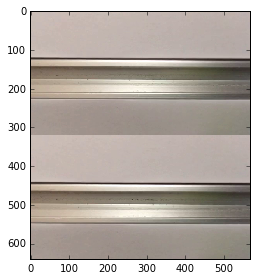

In [39]:
imshow(image)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


(array([1031, 1031, 1031, ..., 3080, 3080, 3080]),
 array([2485, 2486, 2487, ...,  966,  967,  968]))

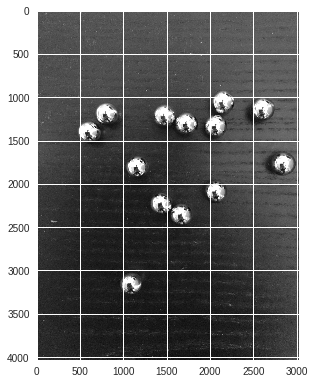

In [8]:
img_rgb_original=cv2.imread('/content/drive/My Drive/ColabSandbox/data/IMG_3709.jpg')
img_rgb=img_rgb_original.copy()
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
imshow(img_gray)


w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.69
loc = np.where( res >= threshold)
loc


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


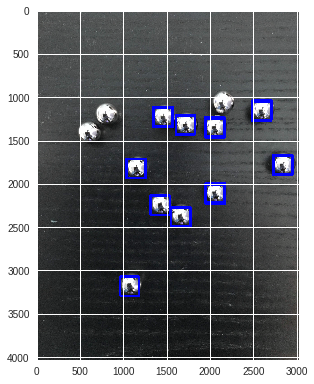

In [9]:
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
imshow(img_rgb)

In [0]:
# image cutting

matched_imgs=[]
for pt in zip(*loc[::-1]):
    #cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    matched_imgs.append(img_gray[pt[1]: pt[1] + h,pt[0]:pt[0] + w])

In [11]:
matched_imgs_resize=[ImageDonwSamplingAndScaling(img,6,max_value=255) for img in matched_imgs]
anomaly_resize=ImageDonwSamplingAndScaling(anomaly,6,max_value=255)
template_resize=ImageDonwSamplingAndScaling(template,6,max_value=255)
anomaly_resize.shape

(36, 36)

In [12]:
len(matched_imgs_resize)

6832

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


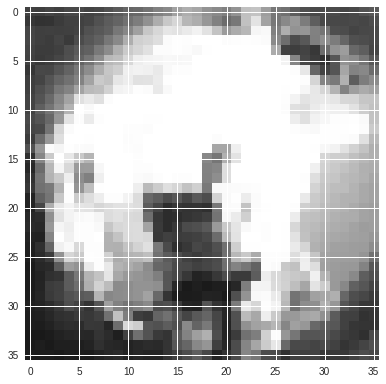

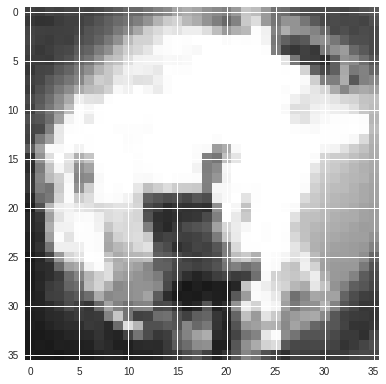

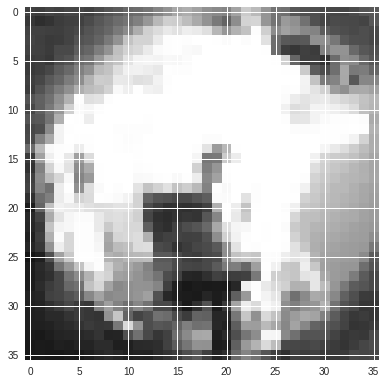

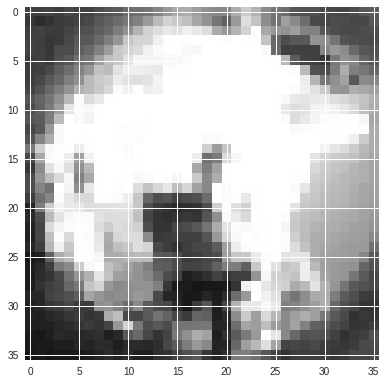

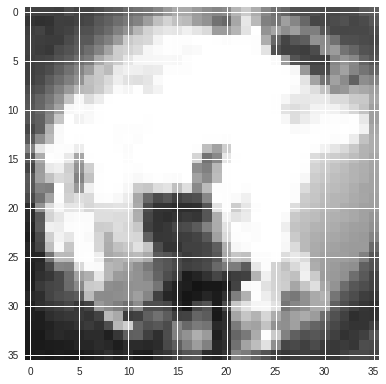

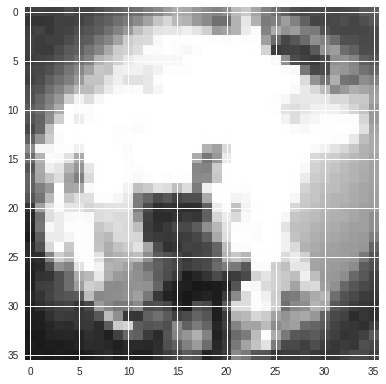

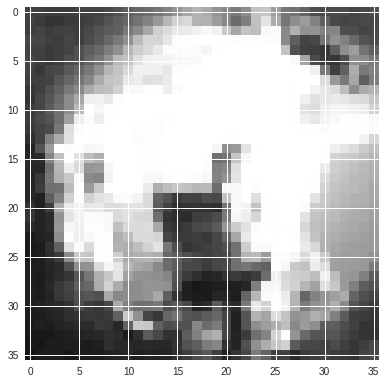

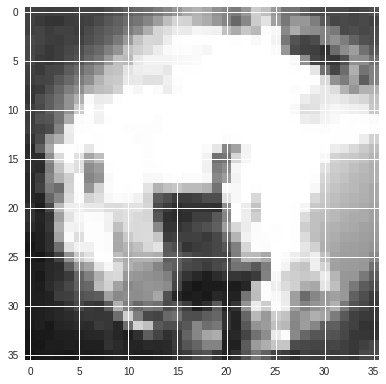

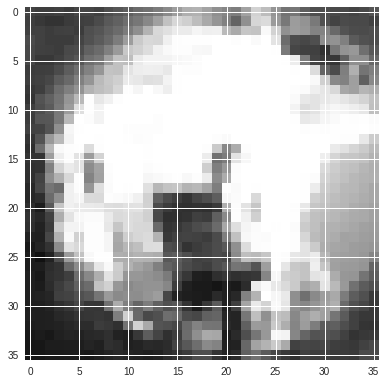

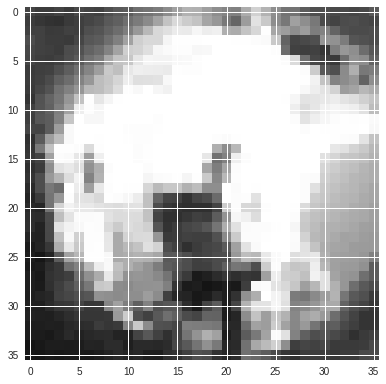

In [13]:
for matched_img in matched_imgs_resize[:10]:
  fig=plt.figure()
  imshow(matched_img)
  plt.show()

In [14]:
image_size=8

sampling_num=20
cut_imgs=img_sampler(img_list=matched_imgs_resize,number=sampling_num, height=image_size, width=image_size)[:,:,:,None]
cut_imgs.shape

(136640, 8, 8, 1)

In [15]:
np.max(cut_imgs)

1.0

In [16]:
# network parameters
input_shape=(image_size, image_size, 1)
batch_size = 128
latent_dim = 2
epochs = 10
Nc = 64


# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(Nc, kernel_size=2, strides=2)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(2*Nc, kernel_size=2, strides=2)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(2*Nc, kernel_size=2, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2DTranspose(Nc, kernel_size=2, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x1 = Conv2DTranspose(1, kernel_size=4, padding='same')(x)
x1 = BatchNormalization()(x1)
out1 = Activation('sigmoid')(x1)#out.shape=(n,8,8,1)

x2 = Conv2DTranspose(1, kernel_size=4, padding='same')(x)
x2 = BatchNormalization()(x2)
out2 = Activation('sigmoid')(x2)#out.shape=(n,8,8,1)

decoder = Model(latent_inputs, [out1, out2], name='decoder')
decoder.summary()

# build VAE model
outputs_mu, outputs_sigma = decoder(encoder(inputs)[2])
vae = Model(inputs, [outputs_mu, outputs_sigma], name='vae_mlp')

# VAE loss
m_vae_loss = (K.flatten(inputs) - K.flatten(outputs_mu))**2 / (K.flatten(outputs_sigma))**2
m_vae_loss = 0.5 * K.sum(m_vae_loss)

a_vae_loss = K.log(2 * 3.14 * (K.flatten(outputs_sigma))**2)
a_vae_loss = 0.5 * K.sum(a_vae_loss)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(kl_loss + m_vae_loss + a_vae_loss)/(image_size**2)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 4, 64)     320         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 4, 4, 64)     256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 4, 4, 64)     0           batch_normalization_1[0][0]      
_____________________________________

In [17]:
# train the autoencoder
vae.fit(cut_imgs,
        epochs=20,
        batch_size=batch_size)
        #validation_data=(x_test, None))


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
136640/136640 [==============================] - 24s 175us/step - loss: -3.2472
Epoch 2/20
136640/136640 [==============================] - 22s 158us/step - loss: -67.9017
Epoch 3/20
136640/136640 [==============================] - 21s 156us/step - loss: -79.1743
Epoch 4/20
136640/136640 [==============================] - 21s 156us/step - loss: -85.9984
Epoch 5/20
136640/136640 [==============================] - 21s 156us/step - loss: -88.5798
Epoch 6/20
136640/136640 [==============================] - 21s 156us/step - loss: -89.5732
Epoch 7/20
136640/136640 [==============================] - 21s 156us/step - loss: -87.4583
Epoch 8/20
136640/136640 [==============================] - 21s 156us/step - loss: -92.4998
Epoch 9/20
136640/136640 [==============================] - 21s 156us/step - loss: -95.8267
Epoch 10/20
136640/136640 [==============================] - 21s 156us/step - loss: -94.5758
Epoch 11/20
136640/136640 [=====

In [56]:
# train the autoencoder
vae.fit(cut_imgs,
        epochs=15,
        batch_size=batch_size)
        #validation_data=(x_test, None))

Epoch 1/15
136640/136640 [==============================] - 23s 171us/step - loss: -134.0705
Epoch 2/15
136640/136640 [==============================] - 23s 170us/step - loss: -136.8923
Epoch 3/15
136640/136640 [==============================] - 23s 169us/step - loss: -139.5059
Epoch 4/15
136640/136640 [==============================] - 23s 169us/step - loss: -135.3783
Epoch 5/15
136640/136640 [==============================] - 23s 169us/step - loss: -139.0232
Epoch 6/15
136640/136640 [==============================] - 23s 169us/step - loss: -140.2808
Epoch 7/15
136640/136640 [==============================] - 23s 169us/step - loss: -122.6347
Epoch 8/15
136640/136640 [==============================] - 23s 170us/step - loss: -138.7863
Epoch 9/15
136640/136640 [==============================] - 23s 170us/step - loss: -142.5840
Epoch 10/15
136640/136640 [==============================] - 23s 169us/step - loss: -135.1114
Epoch 11/15
136640/136640 [==============================] - 23s 169u

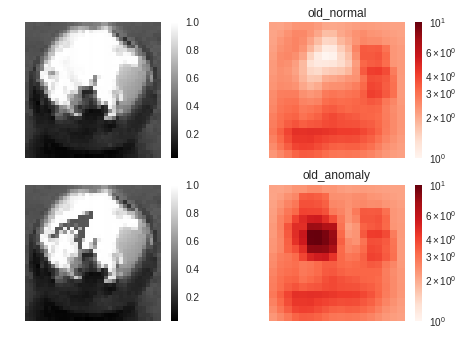

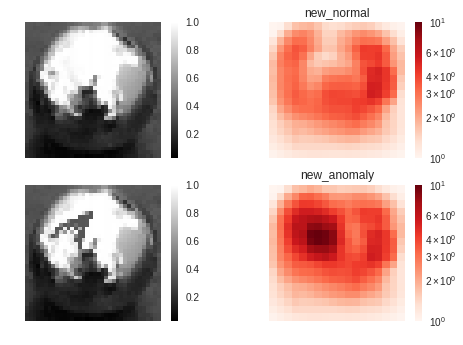

In [18]:
#従来手法の可視化
evaluate_img(vae, template_resize[None,:,:,None], anomaly_resize[None,:,:,None], "old_",height=image_size, width=image_size, move=2)

#提案手法の可視化
evaluate_img(vae,  template_resize[None,:,:,None], anomaly_resize[None,:,:,None], "new_",height=image_size, width=image_size, move=2)

In [0]:
#ヒートマップの計算
def evaluate_img2(model, x_normal, x_anomaly, name, height=8, width=8, move=2):
    img_normal = np.zeros((x_normal.shape))
    img_anomaly = np.zeros((x_normal.shape))
    img_subtract = np.zeros((x_normal.shape))

    for i in range(int((x_normal.shape[1]-height)/move)+1):
        for j in range(int((x_normal.shape[2]-width)/move)+1):
            x_sub_normal = x_normal[0, i*move:i*move+height, j*move:j*move+width, 0]
            x_sub_anomaly = x_anomaly[0, i*move:i*move+height, j*move:j*move+width, 0]
            x_sub_normal = x_sub_normal.reshape(1, height, width, 1)
            x_sub_anomaly = x_sub_anomaly.reshape(1, height, width, 1)

            #従来手法
            if name == "old_":
                #正常のスコア
                normal_score = model.evaluate(x_sub_normal, batch_size=1, verbose=0)
                img_normal[0, i*move:i*move+height, j*move:j*move+width, 0] +=  normal_score

                #異常のスコア
                anomaly_score = model.evaluate(x_sub_anomaly, batch_size=1, verbose=0)
                img_anomaly[0, i*move:i*move+height, j*move:j*move+width, 0] +=  anomaly_score
                
              

            #提案手法
            else:
                #正常のスコア
                mu, sigma = model.predict(x_sub_normal, batch_size=1, verbose=0)
                loss = 0
                for k in range(height):
                    for l in range(width):
                        loss += 0.5 * (x_sub_normal[0,k,l,0] - mu[0,k,l,0])**2 / sigma[0,k,l,0]
                img_normal[0, i*move:i*move+height, j*move:j*move+width, 0] +=  loss

                #異常のスコア
                mu, sigma = model.predict(x_sub_anomaly, batch_size=1, verbose=0)
                loss = 0
                for k in range(height):
                    for l in range(width):
                        loss += 0.5 * (x_sub_anomaly[0,k,l,0] - mu[0,k,l,0])**2 / sigma[0,k,l,0]
                        
                img_anomaly[0, i*move:i*move+height, j*move:j*move+width, 0] +=  loss

    img_subtract=img_anomaly-img_normal
    save_img(x_normal, x_anomaly, img_normal,img_subtract, name)


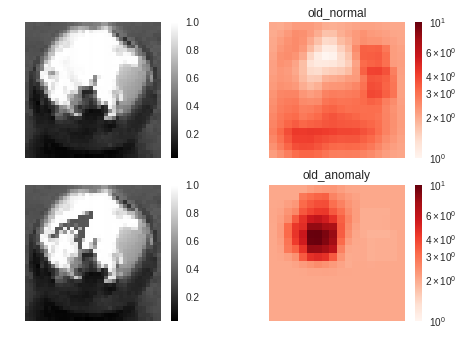

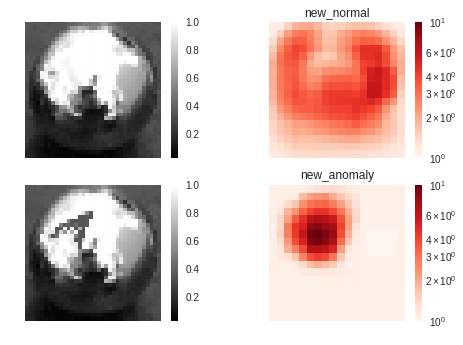

In [21]:
#従来手法の可視化
evaluate_img2(vae, template_resize[None,:,:,None], anomaly_resize[None,:,:,None], "old_",height=image_size, width=image_size, move=2)

#提案手法の可視化
evaluate_img2(vae,  template_resize[None,:,:,None], anomaly_resize[None,:,:,None], "new_",height=image_size, width=image_size, move=2)

In [0]:
#提案手法の可視化
anomaly_map=GetAnomaly(vae,  template_resize[None,:,:,None], anomaly_resize[None,:,:,None])[0,:,:,0]

In [24]:
anomaly_map.max()

0.9006026810240297

In [25]:
anomaly_resize.shape

(36, 36)

In [38]:
# ヒートマップの後処理
heatmap=anomaly_map

heatmap=np.exp(heatmap)-1
heatmap/=np.max(heatmap)

# cv2を使って元画像を読み込む
img = anomaly_rgb

# 元の画像と同じサイズになるようにヒートマップのサイズを変更
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# ヒートマップをRGBに変換
heatmap = np.uint8(255 * heatmap)

# ヒートマップを元画像に適用
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)[:,:,::-1]
print(heatmap.shape)

# 0.4はヒートマップの強度係数
#superimposed_img = heatmap * 0.4 + img
dst = cv2.addWeighted(img, 0.8, heatmap, 0.3, 0)
imshow(img)
plt.show()
imshow(dst)

(221, 221, 3)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


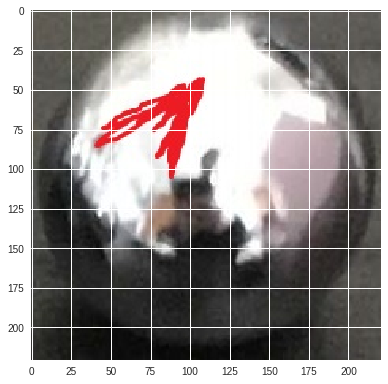

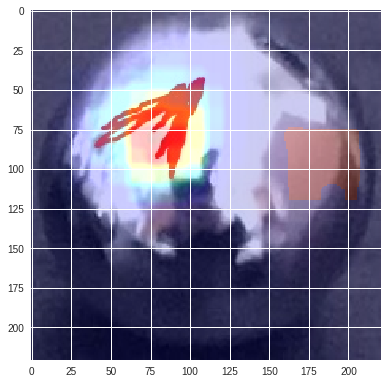

In [41]:
# 0.4はヒートマップの強度係数
#superimposed_img = heatmap * 0.4 + img
dst = cv2.addWeighted(img, 0.8, heatmap, 0.3, 0)
imshow(img)
plt.show()
imshow(dst)